In [14]:
import pandas as pd
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, Point
from folium.plugins import Draw
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

In [15]:
# Read the GeoPackage file
gdf_study_area = gpd.read_file('crop_type_mapping.gpkg')
# print(gdf_study_area.head())

API_key1 = 'd36967d7d3de0af469994b9e04a90f7d2d1c4b8d'
form_id1 = 'aovoywFsugJoqquYc9RoPN'
kobo_base_url1 = 'https://kf.kobotoolbox.org/api/v2'
from koboextractor import KoboExtractor
# Initialize the instance of KoboExtractor
kobo = KoboExtractor(API_key1, kobo_base_url1)
data = kobo.get_data(form_id1, query=None, start=None, limit=None, submitted_after= None)
df1 = pd.json_normalize(data['results'])
# # preview your data
# df1.head(2)

# Extract base column names by removing prefixes up to the last slash
df1.columns = [col.split('/')[-1] for col in df1.columns]

# Merge columns with the same base name
merged_df1 = df1.groupby(level=0, axis=1).apply(lambda x: x.ffill(axis=1).bfill(axis=1).iloc[:, 0])

API_key = 'd36967d7d3de0af469994b9e04a90f7d2d1c4b8d'
form_id = 'aovoywFsugJoqquYc9RoPN'
kobo_base_url= 'https://kf.kobotoolbox.org/api/v2'

from koboextractor import KoboExtractor
# Initialize the instance of KoboExtractor
kobo = KoboExtractor(API_key, kobo_base_url)
data = kobo.get_data(form_id, query=None, start=None, limit=None, submitted_after= None)
df2 = pd.json_normalize(data['results'])
# # preview your data
# df2.head(2)

# Extract base column names by removing prefixes up to the last slash
df2.columns = [col.split('/')[-1] for col in df2.columns]

# Merge columns with the same base name
merged_df2 = df2.groupby(level=0, axis=1).apply(lambda x: x.ffill(axis=1).bfill(axis=1).iloc[:, 0])


merged_df = pd.concat([merged_df1, merged_df2], axis=1)
# Merge columns with the same base name
merged_df = merged_df.groupby(level=0, axis=1).apply(lambda x: x.ffill(axis=1).bfill(axis=1).iloc[:, 0])


C:\Users\SSAPKOTA\AppData\Local\Temp\ipykernel_1116\4236089760.py:20: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged_df1 = df1.groupby(level=0, axis=1).apply(lambda x: x.ffill(axis=1).bfill(axis=1).iloc[:, 0])
C:\Users\SSAPKOTA\AppData\Local\Temp\ipykernel_1116\4236089760.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged_df2 = df2.groupby(level=0, axis=1).apply(lambda x: x.ffill(axis=1).bfill(axis=1).iloc[:, 0])
C:\Users\SSAPKOTA\AppData\Local\Temp\ipykernel_1116\4236089760.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged_df = merged_df.groupby(level=0, axis=1).apply(lambda x: x.ffill(axis=1).bfill(axis=1).iloc[:, 0])
C:\Users\SSAPKOTA\AppData\Local\Temp\ipykernel_1116\4236089760.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecat

In [16]:
required_columns = ['GPS_point', 'Plot_size', '_geolocation', '_id', '_notes',
                    '_submission_time', '_uuid', 'area_in_hectare', 'crop_monsoon',
                    'crop_summer', 'crop_summer_001', 'crop_summer_1', 'crop_winter',
                    'crop_winter_001', 'crop_winter_1', 'deviceid', 'district',
                    'enum_name', 'harvest_date_mon', 'harvest_date_summ',
                    'harvest_date_winter', 'image', 'other_crop_monsoon',
                    'other_crop_summer', 'palika', 'plot_area', 'remarks',
                    'rounded_shape_area', 'shape', 'shape_area', 'sowing_date_mon',
                    'sowing_date_summ', 'sowing_date_winter', 'yield_mons',
                    'yield_summ', 'yield_summ_1', 'yield_winter', 'yield_winter_1']

merged_df = merged_df[required_columns]

# Mapping dictionaries for district and palikas
district_mapping = {
    '1': 'Kailali',
    '2': 'Kanchanpur',
    '3': 'Bardiya'
}

palika_mapping = {
    '11': 'Belauri',
    '12': 'Punarbas',
    '13': 'Janaki',
    '14': 'Lamki Chuha',
    '15': 'Madhuban',
    '16': 'Barbardiya'
}

# Replace values
merged_df['district'] = merged_df['district'].replace(district_mapping)
merged_df['palika'] = merged_df['palika'].replace(palika_mapping)


## now let us count the numner of crops for each district
kailali_df = merged_df[merged_df['district'] == 'Kailali']
kanchanpur_df = merged_df[merged_df['district'] == 'Kanchanpur']
bardiya_df = merged_df[merged_df['district'] == 'Bardiya']


In [17]:
# Mapping of similar crop names to a standardized name
crop_mapping = {
    'rice': ['rice'],
    'maize': ['maize'],
    'grassland': ['grassland'],
    'shrub_tree': ['shrub_tree'],
    'other_monsoon': ['other_monsoon'],
    'banana': ['banana'],
    'black_gram': ['black_grams', 'Black gram', 'Black Grams', 'black _gram', 'Blackgram', 'Blakgrams', 'black_gram'],
    'fallow': ['fallow'],
    'ground_nut': ['ground_nut', 'Groundnut'],
    'other_summer': ['other_summer'],
    'tomato': ['tomato'],
    'sugarcane': ['sugarcane'],
    'chilly': ['chilly', 'Chilly', 'Chilly ', 'chilly '],
    'bottle_gourd': ['bottle guard', 'bottle gourd'],
    'cucumber': ['Cucumber', 'cucumber', 'Cucumber '],
    'wheat': ['wheat', 'Wheat'],
    'mustard': ['mustard', 'Mustard', 'Mustard ', 'MUSTARD', 'Tori', 'tori', 'Tori (mustard)', 'mustard '],
    'lentil': ['lentil', 'Lentil', 'Lentils', 'Lenti', 'lentils', 'Lentil ', 'masuro', 'Masuro', 'musuro', 'masuro (lentil)'],
    'potato': ['potato', 'Potato'],
    'garlic': ['garlic'],
    'onion': ['onion', 'Onion'],
    'pea': ['pea', 'Pea'],
    'soyabean': ['soyabean', 'Soyabean', 'Soyabeans'],
    'vegetables': [
        'bitter guard', 'tite karela', "Lady's finger", "lady'sfinger", "lady's finger ", 
        "Lady's fingers", "lady's finger", 'radish', 'Farsi', 'Bean', 'Radish', 
        'bhanta', 'Cauliflower', 'cauliflower', 'Cucumber', 'cucumber', 'Cucumber ', 
        'Cabbage', 'cabbage', 'bottle guard', 'bottle gourd', 'tomato', 'bottle_gourd', 
        'brinjal', 'Vindi', 'Lauka', 'bitter_gourd', 'lady_finger', 'Bodi', 'pea', 'bean'
    ],
    'mentha': ['mentha'],
    'mung': ['mung'],
    'watermelon': ['Watermelon'],
    'tori': ['Tori', 'tori', 'Tori (mustard)'],
    'mole': ['Mole', 'mole', 'Til'],
    'vegetable_mixes': [
        'lauki makai  mix lagako', 'Laura, bodi kakra', 'Rayo ,kakara  karela', 
        'Kakara, khursani, boldi', 'Lauka,  bodi, karela', 'Lauki ,bodi', 
        'Lauka, bhindi, kakara', 'Bodi, kakara, lauka', 'Lauki ,bodi, karela,kakra', 
        'kakra ra karela', 'Bodi,karela', 'farsi_mix'
    ]
}

# Function to standardize crop names
def standardize_crop_name(crop):
    for standard_name, variations in crop_mapping.items():
        if crop in variations:
            return standard_name
    return crop  # Return original if not found in the mapping

# Updated function to count crop occurrences
def count_crop_occurrences(df, crop_columns):
    crop_counts = {}
    for column in crop_columns:
        df.loc[:, column] = df[column].apply(standardize_crop_name)  # Standardize names
        counts = df[column].value_counts()
        for crop, count in counts.items():
            if crop in crop_counts:
                crop_counts[crop] += count
            else:
                crop_counts[crop] = count
    return crop_counts

# Define crop columns you want to analyze
crop_columns = ['crop_monsoon', 'crop_summer', 'crop_summer_001', 'crop_summer_1',
                'crop_winter', 'crop_winter_001', 'crop_winter_1', 'other_crop_monsoon',
                'other_crop_summer']  # List of your crop columns

# Count crop occurrences for each district with standardized names
kailali_crop_counts = count_crop_occurrences(kailali_df, crop_columns)
kanchanpur_crop_counts = count_crop_occurrences(kanchanpur_df, crop_columns)
bardiya_crop_counts = count_crop_occurrences(bardiya_df, crop_columns)

print("Kailali Crop Counts (Standardized):")
print(kailali_crop_counts)

print("\nKanchanpur Crop Counts (Standardized):")
print(kanchanpur_crop_counts)

print("\nBardiya Crop Counts (Standardized):")
print(bardiya_crop_counts)



Kailali Crop Counts (Standardized):
{'rice': 363, 'maize': 114, 'grassland': 47, 'shrub_tree': 51, 'other_monsoon': 10, 'banana': 30, 'black_gram': 5, 'fallow': 270, 'ground_nut': 1, 'other_summer': 16, 'multiple_crops': 6, 'tomato': 7, 'sugarcane': 2, 'vegetables': 30, 'bottle_gourd': 3, 'chilly': 5, 'cucumber': 5, 'wheat': 159, 'multiple_crops_1': 94, 'mustard': 168, 'potato': 27, 'other_winter': 6, 'lentil': 81, 'garlic': 6, 'onion': 2, 'pea': 1, 'Millet': 1, 'Dhaicha': 2, 'mung': 1, 'watermelon': 1, 'mentha': 1}

Kanchanpur Crop Counts (Standardized):
{'rice': 323, 'sugarcane': 230, 'maize': 156, 'grassland': 69, 'shrub_tree': 66, 'banana': 51, 'fallow': 302, 'other_monsoon': 13, 'black_gram': 6, 'ground_nut': 2, 'other_summer': 28, 'multiple_crops': 1, 'soyabean': 3, 'tomato': 3, 'wheat': 176, 'mustard': 181, 'multiple_crops_1': 37, 'potato': 34, 'lentil': 49, 'vegetables': 14, 'other_winter': 3, 'garlic': 2, 'pea': 3, 'onion': 3, 'chana': 1, 'mole': 8, 'Bhanta': 1, 'tane bodi': 1

In [18]:
def separate_crops(row):
    crops = []
    yields = []
    seasons = []

    # Handle winter crops
    if row['crop_winter'] == 'multiple_crops_1':
        if pd.notna(row['crop_winter_1']):
            crops.append(row['crop_winter_1'])
            yields.append(row['yield_winter'])
            seasons.append('winter')
        if pd.notna(row['crop_winter_001']):
            crops.append(row['crop_winter_001'])
            yields.append(row['yield_winter_1'])
            seasons.append('winter')
    else:
        crops.append(row['crop_winter'])
        yields.append(row['yield_winter'])
        seasons.append('winter')

    # Handle summer crops
    if row['crop_summer'] == 'multiple_crops':
        if pd.notna(row['crop_summer_1']):
            crops.append(row['crop_summer_1'])
            yields.append(row['yield_summ'])
            seasons.append('summer')
        if pd.notna(row['crop_summer_001']):
            crops.append(row['crop_summer_001'])
            yields.append(row['yield_summ_1'])
            seasons.append('summer')
    else:
        crops.append(row['crop_summer'])
        yields.append(row['yield_summ'])
        seasons.append('summer')

    # Handle other summer crops
    if pd.notna(row['other_crop_summer']):
        crops.append(row['other_crop_summer'])
        yields.append(row['yield_summ'])
        seasons.append('summer')

    # Handle monsoon crops
    if row['crop_monsoon'] == 'multiple_crops':
        if pd.notna(row['other_crop_monsoon']):
            crops.append(row['other_crop_monsoon'])
            yields.append(row['yield_mons'])
            seasons.append('monsoon')
    else:
        crops.append(row['crop_monsoon'])
        yields.append(row['yield_mons'])
        seasons.append('monsoon')
    # Handle other monsoon crop
    if pd.notna(row['other_crop_monsoon']):
        crops.append(row['other_crop_monsoon'])
        yields.append(row['yield_mons'])
        seasons.append('monsoon')

    rows = []
    for crop, yield_, season in zip(crops, yields, seasons):
        new_row = row.copy()
        new_row['crop'] = crop
        new_row['yield'] = yield_
        new_row['season'] = season
        rows.append(new_row)

    return rows

# Function to expand a district dataframe using the separate_crops function
def expand_district_df(df):
    expanded_rows = []
    for idx, row in df.iterrows():
        expanded_rows.extend(separate_crops(row))
    return pd.DataFrame(expanded_rows)

In [19]:
# Expand each district dataframe
kailali_expanded_df = expand_district_df(kailali_df)
kanchanpur_expanded_df = expand_district_df(kanchanpur_df)
bardiya_expanded_df = expand_district_df(bardiya_df)

In [20]:
# Remove rows where 'crop' is 'other_summer' or 'other_monsoon'
kailali_expanded_df = kailali_expanded_df[~kailali_expanded_df['crop'].isin(['other_summer', 'other_monsoon'])]
kanchanpur_expanded_df = kanchanpur_expanded_df[~kanchanpur_expanded_df['crop'].isin(['other_summer', 'other_monsoon'])]
bardiya_expanded_df = bardiya_expanded_df[~bardiya_expanded_df['crop'].isin(['other_summer', 'other_monsoon'])]

def count_crops_per_season(df):
    return df.groupby(['palika', 'season'])['crop'].value_counts()


# Get the crop counts per season for each district
kailali_crops_per_season = count_crops_per_season(kailali_expanded_df)
kanchanpur_crops_per_season = count_crops_per_season(kanchanpur_expanded_df)
bardiya_crops_per_season = count_crops_per_season(bardiya_expanded_df)

# print(kailali_crops_per_season)
kailali_crops_per_season.to_csv('kailali_crops_per_season.csv')
kanchanpur_crops_per_season.to_csv('kanchanpur_crops_per_season.csv')
bardiya_crops_per_season.to_csv('bardiya_crops_per_season.csv')

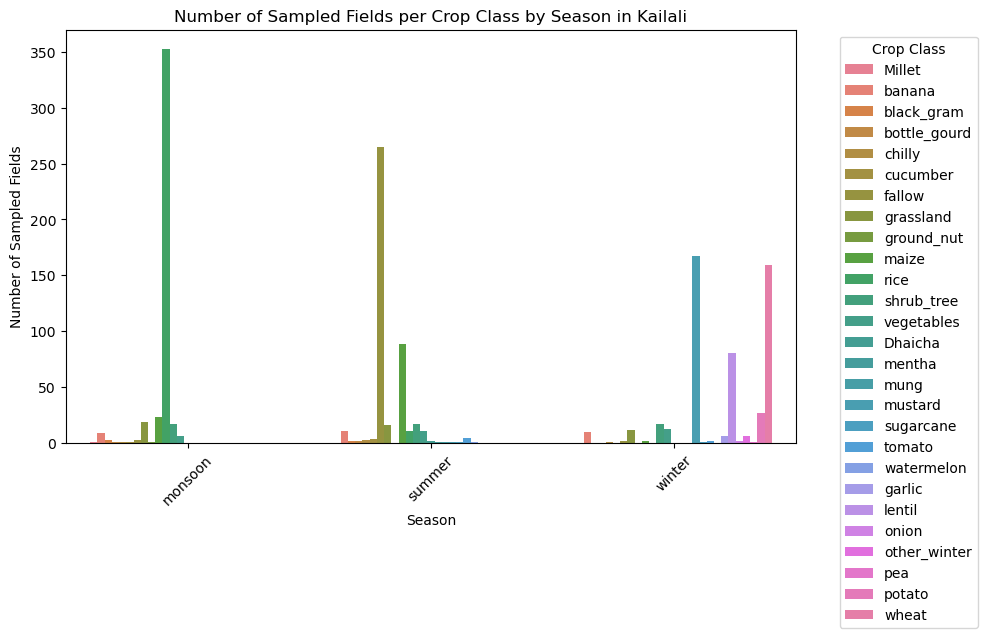

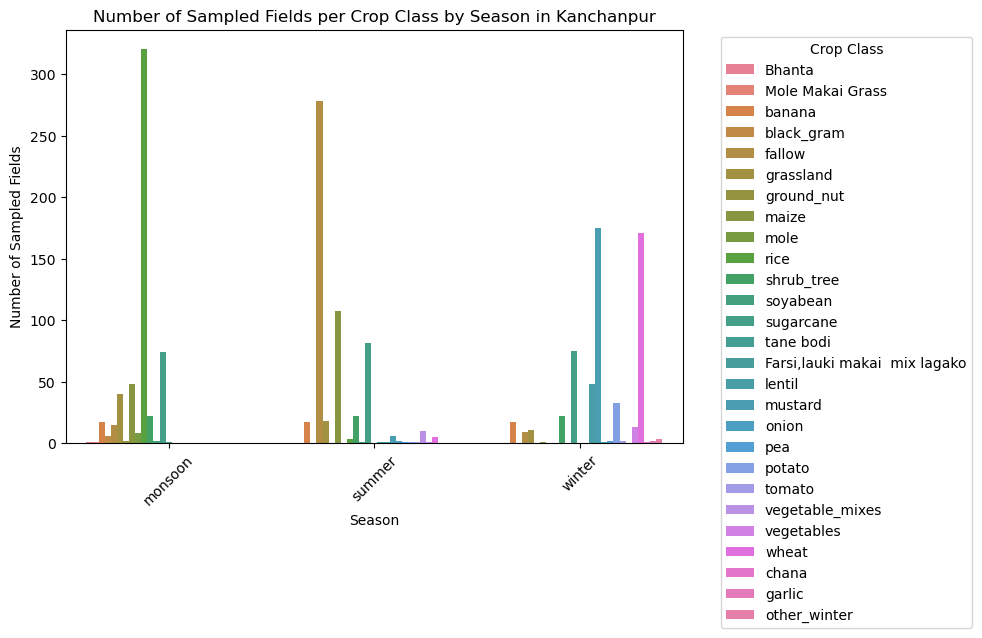

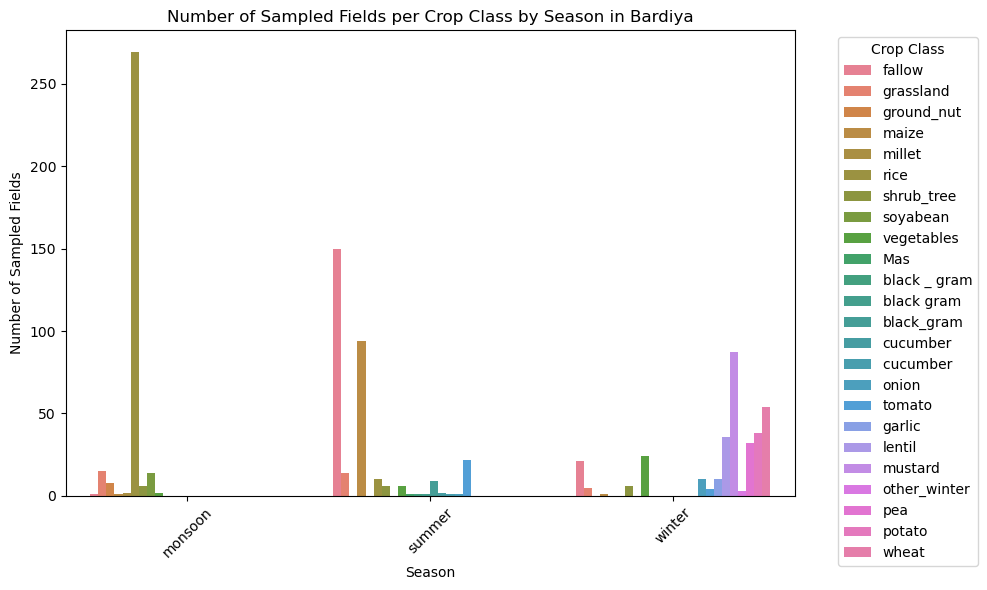

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create plots for each district
def plot_crop_classes_per_season(df, district_name):
    # Count the number of sampled fields per crop class for each season
    grouped_season_df = df.groupby(['season', 'crop']).size().reset_index(name='count')

    # Create a plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped_season_df, x='season', y='count', hue='crop')
    plt.title(f'Number of Sampled Fields per Crop Class by Season in {district_name}')
    plt.xlabel('Season')
    plt.ylabel('Number of Sampled Fields')
    plt.legend(title='Crop Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for Kailali
plot_crop_classes_per_season(kailali_expanded_df, 'Kailali')

# Plot for Kanchanpur
plot_crop_classes_per_season(kanchanpur_expanded_df, 'Kanchanpur')

# Plot for Bardiya
plot_crop_classes_per_season(bardiya_expanded_df, 'Bardiya')

In [22]:
import pandas as pd

# Ensure _geolocation does not contain NoneType values within lists
def is_valid_geolocation(geo):
    # Check if geo is a list or tuple with two elements, and both elements are not None
    return isinstance(geo, (list, tuple)) and len(geo) == 2 and all(g is not None for g in geo)

# Apply the function to filter rows
def clean_geolocation(df):
    return df[df['_geolocation'].apply(is_valid_geolocation)]

# Clean the geolocation data for each district
kailali_expanded_df = clean_geolocation(kailali_expanded_df)
kanchanpur_expanded_df = clean_geolocation(kanchanpur_expanded_df)
bardiya_expanded_df = clean_geolocation(bardiya_expanded_df)

In [ ]:
import folium
import geopandas as gpd
from shapely.geometry import Polygon, Point
from folium.plugins import Draw
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Function to parse coordinates and create Polygon objects with (lon, lat) order
def parse_polygon_coordinates(geo_shape):
    coords = [(float(coord.split()[1]), float(coord.split()[0])) for coord in geo_shape.split(';')]
    return Polygon(coords)

# Function to parse point coordinates from a list [lat, lon]
def parse_point_coordinates(geo_location):
    lat, lon = geo_location
    return Point(lon, lat)

# Function to create a map for a given GeoDataFrame
def create_map(gdf_polygons, gdf_points, district_name, district_df):
    centroid = gdf_points['geometry'].iloc[0]
    center = [centroid.y, centroid.x]  # Folium uses (lat, lon) format

    # Initialize the map centered around the chosen polygon
    m = folium.Map(location=center, zoom_start=12, max_zoom=25)

    # Add Google Satellite as the base map
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite',
        name='Google Satellite',
        overlay=True,
        max_zoom=25
    ).add_to(m)

    # Iterate through each polygon in the GeoDataFrame
    for idx, row in gdf_polygons.iterrows():
        geo_json = row['geometry'].__geo_interface__

        # Create a GeoJson object with style function
        folium.GeoJson(
            data=geo_json,
            style_function=lambda x: {
                'fillColor': 'orange',  # Fill color of polygons
                'color': 'black',       # Border color of polygons
                'weight': 2,            # Border thickness
                'fillOpacity': 0.5      # Opacity of fill color
            }
        ).add_to(m)

        # # Calculate and add the centroid of the polygon
        # centroid = row['geometry'].centroid
        # folium.Marker(
        #     location=[centroid.y, centroid.x],
        #     icon=folium.Icon(color='green'),
        # ).add_to(m)

    # Iterate through each point in the GeoDataFrame
    for idx, row in gdf_points.iterrows():
        point_coords = [row.geometry.y, row.geometry.x]

        # Aggregate crop data for the popup
        crop_data = district_df[district_df['_geolocation'].apply(lambda x: x == [row.geometry.y, row.geometry.x])]
        popup_html = ""
        for _, crop_row in crop_data.iterrows():
          popup_html += (
              f"""Enum Name: {crop_row['enum_name']} \n
              Time: {crop_row['_submission_time']}  \n
              Crop: {crop_row['crop']}   \n
              Yield: {crop_row['yield']} \n
              Season: {crop_row['season']}"""
          )

        folium.Marker(
            location=point_coords,
            icon=folium.Icon(color='red'),
            popup=folium.Popup(popup_html, parse_html=True)
        ).add_to(m)

    # Add the study area polygons to the map
    folium.GeoJson(
        gdf_study_area.geometry.__geo_interface__,
        name='Study Area',
        style_function=lambda x: {
            'fillColor': 'blue',
            'color': 'blue',
            'weight': 2,
            'fillOpacity': 0.2
        }
    ).add_to(m)

    # Add Draw Control to the map
    draw = Draw(
        export=True,
        filename=f'{district_name}_draw_data.geojson',
        draw_options={
            'polyline': True,
            'polygon': True,
            'circle': False,
            'rectangle': True,
            'marker': True,
            'circlemarker': False
        },
        edit_options={
            'edit': True,
            'remove': True
        }
    )
    m.add_child(draw)

    # Add Layer control to the map
    folium.LayerControl().add_to(m)

    # Save the map as an HTML file
    m.save(f'{district_name}_map_with_polygons_and_points.html')

    return m

# Ensure _geolocation does not contain NoneType values within lists
def is_valid_geolocation(geo):
    # Check if geo is a list or tuple with two elements, and both elements are not None
    return isinstance(geo, (list, tuple)) and len(geo) == 2 and all(g is not None for g in geo)

# Apply the function to filter rows
def clean_geolocation(df):
    return df[df['_geolocation'].apply(is_valid_geolocation)]

# Apply cleaning function to each district's DataFrame
kailali_expanded_df = clean_geolocation(kailali_expanded_df)
kanchanpur_expanded_df = clean_geolocation(kanchanpur_expanded_df)
bardiya_expanded_df = clean_geolocation(bardiya_expanded_df)

# Function to display map based on selected district
def display_map(district_name):
    district_df = {
        'Kailali': kailali_expanded_df,
        'Kanchanpur': kanchanpur_expanded_df,
        'Bardiya': bardiya_expanded_df
    }[district_name]

    gdf_polygons = gpd.GeoDataFrame(
        district_df,
        geometry=district_df['shape'].apply(parse_polygon_coordinates),
        crs='EPSG:4326'
    )

    gdf_points = gpd.GeoDataFrame(
        district_df,
        geometry=district_df['_geolocation'].apply(parse_point_coordinates),
        crs='EPSG:4326'
    )

    m = create_map(gdf_polygons, gdf_points, district_name, district_df)
    display(m)

# Create a dropdown widget for district selection
district_dropdown = widgets.Dropdown(
    options=['Kailali', 'Kanchanpur', 'Bardiya'],
    value='Kailali',
    description='District:'
)

# Create a button to generate the map
generate_button = widgets.Button(description="Generate Map")

display(HTML("<h3>Please select a district and click on Generate Map to visualize the points and polygons</h3>"))
# Function to handle button click event
def on_button_clicked(b):
    clear_output(wait=True)
    display(district_dropdown, generate_button)
    print("Generating map please wait ....")
    display_map(district_dropdown.value)

# Attach the click event to the button
generate_button.on_click(on_button_clicked)

# Display the dropdown and button widgets
display(district_dropdown, generate_button)


Dropdown(description='District:', index=2, options=('Kailali', 'Kanchanpur', 'Bardiya'), value='Bardiya')

Button(description='Generate Map', style=ButtonStyle())

Generating map please wait ....
